## Импорт данных и библиотек

Импорт библиотек

In [36]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.feature_selection import VarianceThreshold

Подключение к диску

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Импорт датасета

In [102]:
data_train = pd.read_csv("/content/drive/My Drive/Учеба/магистратура/2 сем/ММО/airline_passenger_satisfaction_80.csv")
data_test = pd.read_csv("/content/drive/My Drive/Учеба/магистратура/2 сем/ММО/airline_passenger_satisfaction_20.csv")
data = pd.concat([data_train, data_test])

Для задачи 1 и дполнительного задания будем рассматривать набор с оценками пассажиров о качестве разных характеристик рейса на самолет. В этом наборе указываются следующие параметры рейса: дистанция и класс полета, время задержки отправления и прибытия. Также присутствуют некоторые характеристики пассажиров: возраст, пол, тип покупателя. Целевой признак набора - satisfaction, означающий, удовлетворен ли пассажир в итоге полетом.

In [60]:
data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Для задания 2 сгенерируем собственный набор, что актуально для задачи с константными/псевдоконстантными признаками.

In [97]:
cols = 5
rows = 1000
np.random.seed(1)

data2 = pd.DataFrame(np.random.randint(1, 5, (rows, cols)), columns=['A', 'B', 'C', 'D', 'E']) #pd.DataFrame(np.random.rand(rows, cols))
data2['D'] = data2['D'].replace([2, 3, 4], [1, 1, 1])
data2['E'] = data2['E'].replace([2, 3, 4], [1, 1, 1])
data2.iat[1, 4] = 5
data2.iat[2, 4] = 5
data2.head()

,A,B,C,D,E
0,2,4,1,1,1
1,2,4,2,1,5
2,1,2,1,1,5
3,1,3,2,1,1
4,3,2,3,1,1


## Задача 1

Проведем устранение пропусков для числового признака "Arrival Delay in Minutes" с использованием метода заполнения "хвостом распределения".

In [103]:
col_name = 'Arrival Delay in Minutes'

Изначально в данном столбце присутсвуют пропуски:

In [104]:
data.isnull().sum()['Arrival Delay in Minutes']

393

Сначала посмотрим распределение колонки:

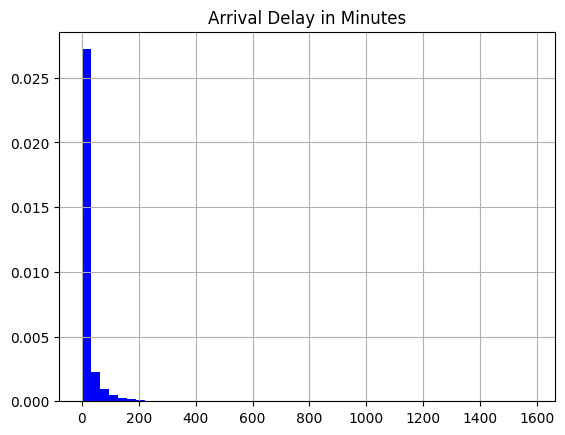

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.title.set_text(col_name)
data[col_name].hist(bins=50, ax=ax, density=True, color='blue')
plt.show()

Поскольку у нас распределение ассиметричное, заполнять пропуски "хвостом распределения" будем значением, которое высчитаем следующей формуле:
extreme_value=Q3+K⋅IQR, где IQR=Q3−Q1. Поскольку у нас есть сильные выбросы - в качестве К возьмем значение 3.

In [106]:
IQR = data[col_name].quantile(0.75) - data[col_name].quantile(0.25)
extreme_value = data[col_name].quantile(0.75) + 3*IQR
print('IQR={}, extreme_value={}'.format(IQR, extreme_value))

IQR=13.0, extreme_value=52.0


Далее определим функцию для заполнения пропусков:

In [107]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]

    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)

    imputer = SimpleImputer(strategy=strategy_param,
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)

    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]

    return all_data.reshape((size,)), filled_data, missed_data

Теперь заполним пропуски и выведем график для сравнения исходного распределения столбца и распределения с заполненными пропусками

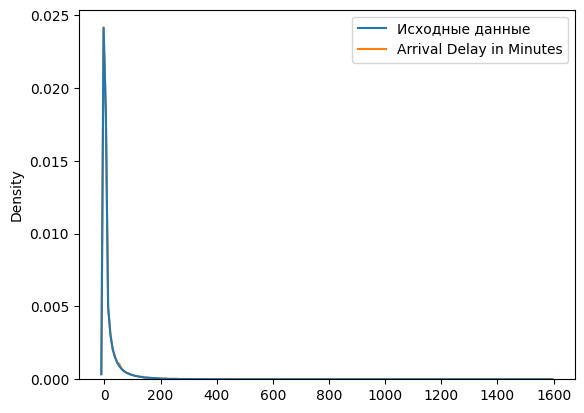

In [108]:
col_filled, _, _ = impute_column(data, col_name, 'constant', extreme_value)

original_temp_data = data[[col_name]].values
size = original_temp_data.shape[0]
original_data = original_temp_data.reshape((size,))
data_to_compare = pd.DataFrame({'Исходные данные':original_data})

data_to_compare[col_name] = col_filled
sns.kdeplot(data=data_to_compare)

data_filled = data.copy(deep=True)
data_filled[col_name] = col_filled

По графику видим, что распределение почти не поменялось, но видна небольшая оранжевая выпуклость для значения 52 (которым мы заполняли пропуски)

Посмотрим, что пропуски были заполнены:

In [109]:
data_filled.isnull().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

## Задача 2

Проведем удаление константных и псевдоконстантных признаков. Такие признаки мало полезны при построении модели, т.к. содержат все одинаковые (константные) или почти все одинаковые (псевдоконстантные) значения.

Будем рассматривать только численные признаки, поэтому удалим из датасета строковые признаки и столбец 'Unnamed: 0', не несущий информации

In [47]:
data_numeric = data_filled.copy(deep=True)
cols_to_drop = [c for c in data_numeric.columns if (data_numeric[c].dtype == 'O')] + ['Unnamed: 0', 'id']
data_numeric.drop(cols_to_drop, axis=1, inplace=True)

У константного признака нулевая дисперсия, а у псевдоконстантного - значение дисперсии очень мало. То есть, чтобы найти константные и псевдоконстантные признаки, найдем значения дисперсий для каждого признака:

In [98]:
data_const_deleted = VarianceThreshold(threshold=0.15)
data_const_deleted.fit(data2)
data_const_deleted.variances_

array([1.263324, 1.265856, 1.266479, 0.      , 0.031936])

Итого получаем набор без константного признака D, который имеет значение дисперсии = 0, и без псевдоконстантного признака Е, который имеет очень малое значение дисперсии

In [99]:
data_const_deleted.transform(data2)

array([[2, 4, 1],
       [2, 4, 2],
       [1, 2, 1],
       ...,
       [3, 3, 3],
       [2, 3, 3],
       [1, 4, 1]])

## Дополнительное задание

Выведем парные графики для нескольких столбцов набора с оценками пассажиров.

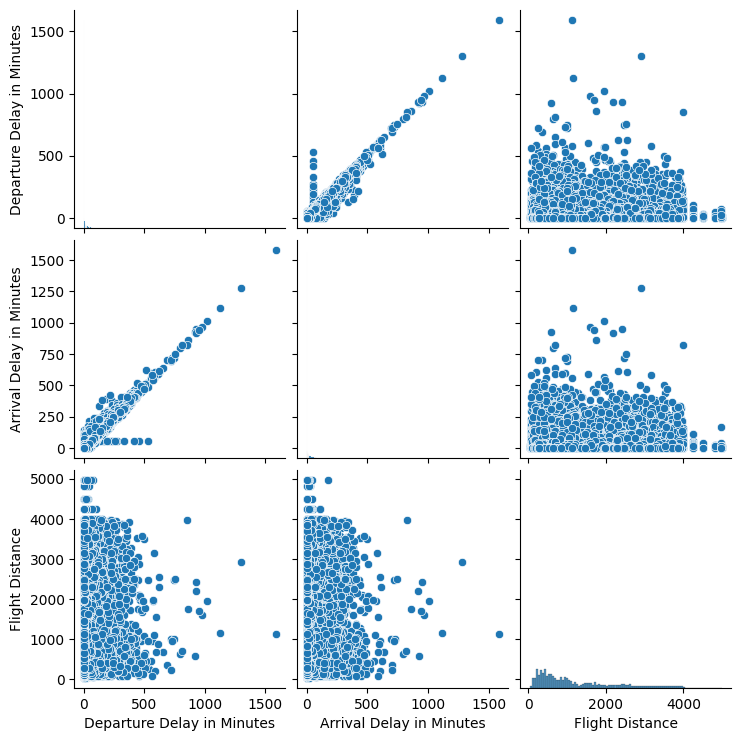

In [110]:
sns.pairplot(data_filled[['Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']])
plt.show()

На основе графиков можем отметить следующее:
- Задержка времени вылета и прилета коррелируют примерно линейно, что логично, т.к. если задерживается вылет, то задерживается и прилет.
- Для дистанции полета, коррелирующей с задержками прилета и вылета, графики корреляции очень похожи. При этом, видно выбросы для больших значений задержки.